# Playground with diffrent model architectures

In [1]:
import re
from typing import List

from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [113]:
%matplotlib inline

## Chosing right columns

In [2]:
df_ = pd.read_csv('data/Tweets.csv')
 # we've changed range from <-1, 1> to the <0, 2> to use it with the sparse_categorical_crossentropy loss function
df_['airline_sentiment'] = df_['airline_sentiment'].replace({'negative': 0, 'neutral': 1, 'positive': 2})

columns_to_use = [
    'airline_sentiment', 'retweet_count', 'text', 'tweet_created'
]

df_ = df_[columns_to_use]
df_.head()

,airline_sentiment,retweet_count,text,tweet_created
0,1,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800
1,2,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800
2,1,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48 -0800
3,0,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36 -0800
4,0,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45 -0800


# First prototype - only text used

In [3]:
df = df_.copy()
feature_sentence = df['text']
target = df['airline_sentiment']

glove_file = datapath('/sentiment-analysis/sentiment/data/glove.6B.100d.txt')
word2vec_glove_file = get_tmpfile("glove.6B.100d.word2vec.txt")
glove2word2vec(glove_file, word2vec_glove_file)
kv_model = KeyedVectors.load_word2vec_format(word2vec_glove_file)

In [4]:
def remove_punctation_marks(msg: str) -> List[str]:
    return list(filter(None, re.split(r'[\W]', msg)))

def lower_str_list(str_list: List[str]) -> List[str]:
    return [w.lower() for w in str_list]

In [5]:
feature_sentence.shape

(14640,)

## Replace words with word vectors using GloVe model

In [6]:
def enocde_phrase_into_word_vectors(
        raw_phrase: str,  model: KeyedVectors) -> List[np.array]:
    
    phrase = lower_str_list(remove_punctation_marks(raw_phrase))
    
    encoded_phrase = []
    for word in phrase:
        if word not in model.vocab:
            continue
        vec = model.get_vector(word)
        encoded_phrase.append(vec)
        
    return encoded_phrase


def split_phrase_into_word_list(s: pd.Series, model: KeyedVectors) -> np.array:
    result = np.empty(s.shape, dtype=list)
    for i, phrase in s.iteritems():
        result[i] = enocde_phrase_into_word_vectors(phrase, model)
    
    return result
    

In [7]:
features = split_phrase_into_word_list(feature_sentence, kv_model)

## Find optimal words amount in sentence

We need all feature rows to be the same length

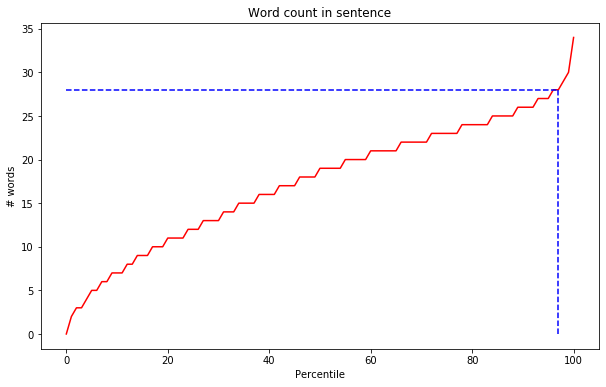

In [9]:
word_count = np.array([len(x) for x in features])
range_ = list(range(0, 101))
percentiles = [np.percentile(word_count, x) for x in range_]

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(range_, percentiles, 'r', [0, 97], [28, 28], '--b', [97, 97], [0, 28], '--b' )

ax.set_xlabel('Percentile')
ax.set_ylabel('# words')
ax.set_title('Word count in sentence')
plt.show()

**We can set sentence length to 28 words and discard only 3% of the data**

In [10]:
max_word_count = 28
features = sequence.pad_sequences(features, dtype='float64', maxlen=max_word_count, padding='post', truncating='post')

In [11]:
features.shape

(14640, 28, 100)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2)

In [13]:
X_train.shape

(11712, 28, 100)

In [14]:
y_train.shape

(11712,)

In [52]:
def defaul_model(
        X_train, X_test, y_train, y_test,
        additional_LSTM_layer = False,
        learning_rate = 0.001,
        decay = 1e-6,
        epochs = 10):
    
    model = Sequential()
    
    model.add(LSTM(128, input_shape=(X_train.shape[1:]), activation='relu', return_sequences=True))
    model.add(Dropout(0.2))
    
    if additional_LSTM_layer:
        model.add(LSTM(128, activation='relu', return_sequences=True))
        model.add(Dropout(0.2))
    
    model.add(LSTM(128, activation='relu'))
    model.add(Dropout(0.1))

    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(3,  activation='softmax'))

    opt = tf.keras.optimizers.Adam(lr=learning_rate, decay=decay)

    # Compile model
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=opt,
        metrics=['accuracy'],
    )

    history = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        validation_data=(X_test, y_test))
    return model, history

In [55]:
history = {}

title = 'Base line architecutre'
_, hist = defaul_model(X_train, X_test, y_train, y_test)

history[title] = hist

Train on 11712 samples, validate on 2928 samples
Epoch 1/10
11712/11712 [==============================] - 41s 3ms/sample - loss: 0.7909 - acc: 0.6551 - val_loss: 0.6173 - val_acc: 0.7326
Epoch 2/10
11712/11712 [==============================] - 52s 4ms/sample - loss: 0.6308 - acc: 0.7459 - val_loss: 0.5777 - val_acc: 0.7725
Epoch 3/10
11712/11712 [==============================] - 52s 4ms/sample - loss: 0.5558 - acc: 0.7859 - val_loss: 0.5734 - val_acc: 0.7790
Epoch 4/10
11712/11712 [==============================] - 42s 4ms/sample - loss: 0.5031 - acc: 0.8050 - val_loss: 0.5093 - val_acc: 0.8084
Epoch 5/10
11712/11712 [==============================] - 33s 3ms/sample - loss: 0.4710 - acc: 0.8177 - val_loss: 0.5062 - val_acc: 0.7947
Epoch 6/10
11712/11712 [==============================] - 31s 3ms/sample - loss: 0.4323 - acc: 0.8372 - val_loss: 0.5089 - val_acc: 0.8050
Epoch 7/10
11712/11712 [==============================] - 32s 3ms/sample - loss: 0.4020 - acc: 0.8479 - val_loss: 0.5

In [56]:
title = 'Additional LSTM layer'
_, hist = defaul_model(X_train, X_test, y_train, y_test, additional_LSTM_layer=True)

history[title] = hist

Train on 11712 samples, validate on 2928 samples
Epoch 1/10
11712/11712 [==============================] - 55s 5ms/sample - loss: 0.7532 - acc: 0.6750 - val_loss: 0.6494 - val_acc: 0.7254
Epoch 2/10
11712/11712 [==============================] - 51s 4ms/sample - loss: 0.6451 - acc: 0.7408 - val_loss: 0.5932 - val_acc: 0.7739
Epoch 3/10
11712/11712 [==============================] - 48s 4ms/sample - loss: 0.5643 - acc: 0.7844 - val_loss: 0.5466 - val_acc: 0.7923
Epoch 4/10
11712/11712 [==============================] - 48s 4ms/sample - loss: 0.5106 - acc: 0.8064 - val_loss: 0.5277 - val_acc: 0.8040
Epoch 5/10
11712/11712 [==============================] - 48s 4ms/sample - loss: 0.4763 - acc: 0.8219 - val_loss: 0.5001 - val_acc: 0.8057
Epoch 6/10
11712/11712 [==============================] - 48s 4ms/sample - loss: 0.4391 - acc: 0.8368 - val_loss: 0.5272 - val_acc: 0.7879
Epoch 7/10
11712/11712 [==============================] - 48s 4ms/sample - loss: 0.3986 - acc: 0.8537 - val_loss: 0.5

In [57]:
title = 'Learning rate 0.0003'
_, hist = defaul_model(X_train, X_test, y_train, y_test, learning_rate=0.0003)

history[title] = hist

Train on 11712 samples, validate on 2928 samples
Epoch 1/10
11712/11712 [==============================] - 40s 3ms/sample - loss: 0.8281 - acc: 0.6332 - val_loss: 0.6968 - val_acc: 0.7039
Epoch 2/10
11712/11712 [==============================] - 37s 3ms/sample - loss: 0.6801 - acc: 0.7120 - val_loss: 0.6082 - val_acc: 0.7520
Epoch 3/10
11712/11712 [==============================] - 38s 3ms/sample - loss: 0.5912 - acc: 0.7666 - val_loss: 0.5543 - val_acc: 0.7760
Epoch 4/10
11712/11712 [==============================] - 39s 3ms/sample - loss: 0.5483 - acc: 0.7861 - val_loss: 0.5353 - val_acc: 0.7845
Epoch 5/10
11712/11712 [==============================] - 33s 3ms/sample - loss: 0.5143 - acc: 0.8015 - val_loss: 0.5105 - val_acc: 0.7982
Epoch 6/10
11712/11712 [==============================] - 36s 3ms/sample - loss: 0.4818 - acc: 0.8173 - val_loss: 0.5091 - val_acc: 0.7975
Epoch 7/10
11712/11712 [==============================] - 33s 3ms/sample - loss: 0.4674 - acc: 0.8216 - val_loss: 0.5

In [58]:
title = 'Learning rate 0.0003 and decay 1e-7'
_, hist = defaul_model(X_train, X_test, y_train, y_test, learning_rate=0.0003, decay=1e-7)

history[title] = hist

Train on 11712 samples, validate on 2928 samples
Epoch 1/10
11712/11712 [==============================] - 38s 3ms/sample - loss: 0.8137 - acc: 0.6358 - val_loss: 0.7220 - val_acc: 0.6936
Epoch 2/10
11712/11712 [==============================] - 34s 3ms/sample - loss: 0.7158 - acc: 0.6890 - val_loss: 0.6389 - val_acc: 0.7285
Epoch 3/10
11712/11712 [==============================] - 46s 4ms/sample - loss: 0.6434 - acc: 0.7252 - val_loss: 0.5978 - val_acc: 0.7527
Epoch 4/10
11712/11712 [==============================] - 32s 3ms/sample - loss: 0.5888 - acc: 0.7650 - val_loss: 0.5544 - val_acc: 0.7753
Epoch 5/10
11712/11712 [==============================] - 34s 3ms/sample - loss: 0.5368 - acc: 0.7918 - val_loss: 0.5630 - val_acc: 0.7934
Epoch 6/10
11712/11712 [==============================] - 33s 3ms/sample - loss: 0.5063 - acc: 0.8024 - val_loss: 0.5032 - val_acc: 0.8026
Epoch 7/10
11712/11712 [==============================] - 35s 3ms/sample - loss: 0.4749 - acc: 0.8192 - val_loss: 0.4

In [59]:
title = 'Learning rate 0.0003 and decay 1e-5'
_, hist = defaul_model(X_train, X_test, y_train, y_test, learning_rate=0.0003, decay=1e-5)

history[title] = hist

Train on 11712 samples, validate on 2928 samples
Epoch 1/10
11712/11712 [==============================] - 37s 3ms/sample - loss: 0.8266 - acc: 0.6337 - val_loss: 0.6965 - val_acc: 0.6960
Epoch 2/10
11712/11712 [==============================] - 28s 2ms/sample - loss: 0.6779 - acc: 0.7209 - val_loss: 0.6198 - val_acc: 0.7575
Epoch 3/10
11712/11712 [==============================] - 28s 2ms/sample - loss: 0.5812 - acc: 0.7742 - val_loss: 0.5394 - val_acc: 0.7944
Epoch 4/10
11712/11712 [==============================] - 27s 2ms/sample - loss: 0.5375 - acc: 0.7904 - val_loss: 0.5286 - val_acc: 0.7988
Epoch 5/10
11712/11712 [==============================] - 27s 2ms/sample - loss: 0.5046 - acc: 0.8087 - val_loss: 0.5171 - val_acc: 0.8043
Epoch 6/10
11712/11712 [==============================] - 27s 2ms/sample - loss: 0.4727 - acc: 0.8186 - val_loss: 0.5210 - val_acc: 0.8009
Epoch 7/10
11712/11712 [==============================] - 27s 2ms/sample - loss: 0.4534 - acc: 0.8267 - val_loss: 0.5

In [60]:
title = 'Decay 1e-5'
_, hist = defaul_model(X_train, X_test, y_train, y_test, decay=1e-5)

history[title] = hist

Train on 11712 samples, validate on 2928 samples
Epoch 1/10
11712/11712 [==============================] - 35s 3ms/sample - loss: 0.8049 - acc: 0.6477 - val_loss: 0.6729 - val_acc: 0.7059
Epoch 2/10
11712/11712 [==============================] - 35s 3ms/sample - loss: 0.6899 - acc: 0.7133 - val_loss: 0.6133 - val_acc: 0.7510
Epoch 3/10
11712/11712 [==============================] - 30s 3ms/sample - loss: 0.5862 - acc: 0.7711 - val_loss: 0.5538 - val_acc: 0.7790
Epoch 4/10
11712/11712 [==============================] - 29s 2ms/sample - loss: 0.5292 - acc: 0.7931 - val_loss: 0.5491 - val_acc: 0.7982
Epoch 5/10
11712/11712 [==============================] - 29s 2ms/sample - loss: 0.4929 - acc: 0.8125 - val_loss: 0.5190 - val_acc: 0.8016
Epoch 6/10
11712/11712 [==============================] - 30s 3ms/sample - loss: 0.4557 - acc: 0.8262 - val_loss: 0.5252 - val_acc: 0.8002
Epoch 7/10
11712/11712 [==============================] - 29s 2ms/sample - loss: 0.4139 - acc: 0.8470 - val_loss: 0.5

In [61]:
title = 'Decay 1e-7'
_, hist = defaul_model(X_train, X_test, y_train, y_test, decay=1e-7)

history[title] = hist

Train on 11712 samples, validate on 2928 samples
Epoch 1/10
11712/11712 [==============================] - 39s 3ms/sample - loss: 0.7732 - acc: 0.6681 - val_loss: 0.6732 - val_acc: 0.7466
Epoch 2/10
11712/11712 [==============================] - 34s 3ms/sample - loss: 0.6208 - acc: 0.7573 - val_loss: 0.5541 - val_acc: 0.7876
Epoch 3/10
11712/11712 [==============================] - 35s 3ms/sample - loss: 0.5565 - acc: 0.7859 - val_loss: 0.5428 - val_acc: 0.7838
Epoch 4/10
11712/11712 [==============================] - 33s 3ms/sample - loss: 0.5044 - acc: 0.8054 - val_loss: 0.5388 - val_acc: 0.7770
Epoch 5/10
11712/11712 [==============================] - 33s 3ms/sample - loss: 0.4581 - acc: 0.8271 - val_loss: 0.5507 - val_acc: 0.7852
Epoch 6/10
11712/11712 [==============================] - 36s 3ms/sample - loss: 0.4338 - acc: 0.8397 - val_loss: 0.5407 - val_acc: 0.7920
Epoch 7/10
11712/11712 [==============================] - 35s 3ms/sample - loss: 0.4192 - acc: 0.8477 - val_loss: 0.5

In [62]:
title = 'Learning rate 0.03 and decay 1e-5'
_, hist = defaul_model(X_train, X_test, y_train, y_test, learning_rate=0.03, decay=1e-5)

history[title] = hist

Train on 11712 samples, validate on 2928 samples
Epoch 1/10
11712/11712 [==============================] - 39s 3ms/sample - loss: 6.0349 - acc: 0.6247 - val_loss: 5.8681 - val_acc: 0.6359
Epoch 2/10
11712/11712 [==============================] - 34s 3ms/sample - loss: 6.0498 - acc: 0.6247 - val_loss: 5.8681 - val_acc: 0.6359
Epoch 3/10
11712/11712 [==============================] - 34s 3ms/sample - loss: 6.0498 - acc: 0.6247 - val_loss: 5.8681 - val_acc: 0.6359
Epoch 4/10
11712/11712 [==============================] - 36s 3ms/sample - loss: 6.0498 - acc: 0.6247 - val_loss: 5.8681 - val_acc: 0.6359
Epoch 5/10
11712/11712 [==============================] - 35s 3ms/sample - loss: 6.0498 - acc: 0.6247 - val_loss: 5.8681 - val_acc: 0.6359
Epoch 6/10
11712/11712 [==============================] - 34s 3ms/sample - loss: 6.0498 - acc: 0.6247 - val_loss: 5.8681 - val_acc: 0.6359
Epoch 7/10
11712/11712 [==============================] - 35s 3ms/sample - loss: 6.0498 - acc: 0.6247 - val_loss: 5.8

In [63]:
title = 'Learning rate 0.03 and decay 1e-7'
_, hist = defaul_model(X_train, X_test, y_train, y_test, learning_rate=0.03, decay=1e-7)

history[title] = hist

Train on 11712 samples, validate on 2928 samples
Epoch 1/10
11712/11712 [==============================] - 44s 4ms/sample - loss: 6.0294 - acc: 0.6237 - val_loss: 5.8681 - val_acc: 0.6359
Epoch 2/10
11712/11712 [==============================] - 40s 3ms/sample - loss: 6.0498 - acc: 0.6247 - val_loss: 5.8681 - val_acc: 0.6359
Epoch 3/10
11712/11712 [==============================] - 35s 3ms/sample - loss: 6.0498 - acc: 0.6247 - val_loss: 5.8681 - val_acc: 0.6359
Epoch 4/10
11712/11712 [==============================] - 35s 3ms/sample - loss: 6.0498 - acc: 0.6247 - val_loss: 5.8681 - val_acc: 0.6359
Epoch 5/10
11712/11712 [==============================] - 38s 3ms/sample - loss: 6.0498 - acc: 0.6247 - val_loss: 5.8681 - val_acc: 0.6359
Epoch 6/10
11712/11712 [==============================] - 41s 4ms/sample - loss: 6.0498 - acc: 0.6247 - val_loss: 5.8681 - val_acc: 0.6359
Epoch 7/10
11712/11712 [==============================] - 29s 2ms/sample - loss: 6.0498 - acc: 0.6247 - val_loss: 5.8

In [64]:
history['Base line architecutre'].history

{'loss': [0.7908708532976974,
  0.6307932496722278,
  0.5557962984172373,
  0.5030523629380705,
  0.47102278902556727,
  0.4322984689042542,
  0.4019926906731285,
  0.3625545494584112,
  0.3309277529863875,
  0.29805666788435375],
 'acc': [0.6550546,
  0.74590164,
  0.78586066,
  0.80498636,
  0.8177083,
  0.83717555,
  0.84793377,
  0.8645833,
  0.87636614,
  0.89173496],
 'val_loss': [0.6173443527169566,
  0.5777205447030198,
  0.5733989123763934,
  0.5092513732245711,
  0.5061762052807001,
  0.5089219702723248,
  0.5156999803631683,
  0.5604452430550518,
  0.5736836210463216,
  0.6676424108242076],
 'val_acc': [0.732582,
  0.772541,
  0.77903,
  0.80840164,
  0.79474044,
  0.80498636,
  0.79747266,
  0.80635244,
  0.8114754,
  0.79474044]}

In [109]:
history
import pickle

for i in history:
    pickle.dump(history[i].history, open(f"save{i}.p", "wb"))

In [98]:
epochs = list(range(1, 11))
legends = []
val_loss = []
val_acc = []
train_loss = []
train_acc = []


for title, hist in history.items():
    legends.append(title)
    val_loss.append(hist.history['val_loss']) 
    val_acc.append(hist.history['val_acc'])
    train_loss.append(hist.history['loss'])
    train_acc.append(hist.history['acc']) 


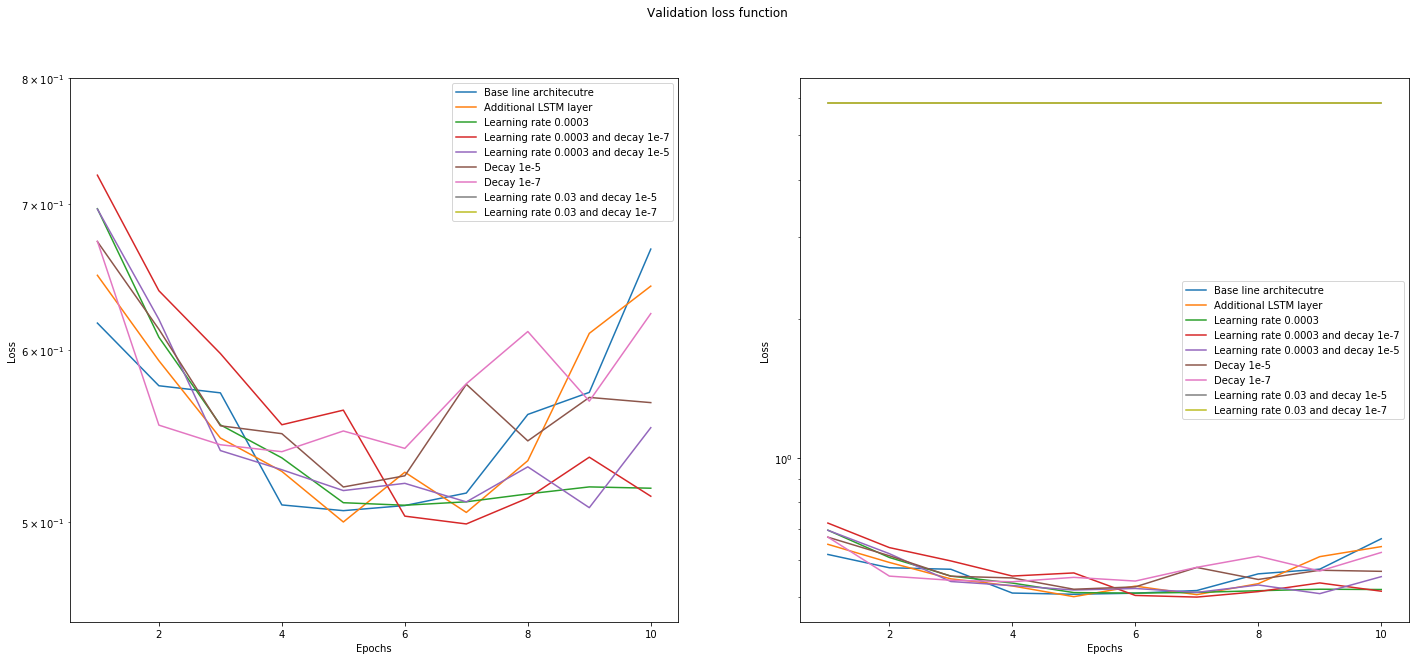

In [124]:
fig, ax = plt.subplots(1, 2, figsize=(24,10))
plt.suptitle('Validation loss function')

ax[0].set_ylim(0.45, 0.8)
for i in range(len(ax)):
    ax[i].set_yscale("log")
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel('Loss')
    
for i in range(len(val_loss)):
    ax[0].plot(epochs, val_loss[i])
    ax[1].plot(epochs, val_loss[i])

    ax[0].legend(labels=legends)
    ax[1].legend(labels=legends)
plt.show()

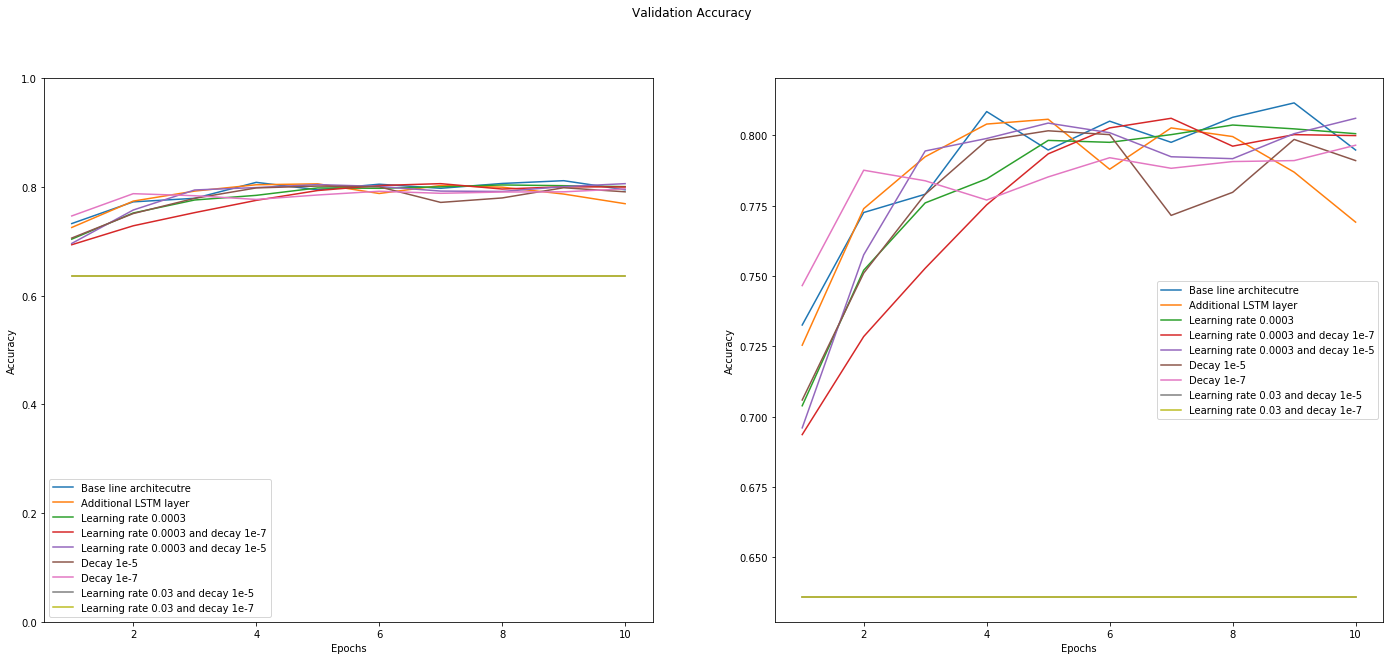

In [205]:
fig, ax = plt.subplots(1, 2, figsize=(24,10))
plt.suptitle('Validation Accuracy')

ax[0].set_ylim(0., 1)
for i in range(len(ax)):
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel('Accuracy')
    
for i in range(len(val_acc)):
    ax[0].plot(epochs, val_acc[i])
    ax[1].plot(epochs, val_acc[i])

    ax[0].legend(labels=legends)
    ax[1].legend(labels=legends)
plt.show()

Almost all trained model were performing quite simmilary, the two exception were the ones with learning rate at 0.03 - it prevented them from finding the local minimum in the cost function.

It is hard to chose the best model but the one with learning rate 0.0003 and decay 1e-5 looks reasonable. The one with additional LSTM layer looks smoother but it takes longer to learn (more parameteres to train)

# Second prototype - text used and tweet metadata
We will now try to combine week day and the rewteet number to get better results

In [140]:
df = df_.copy()
text_feature = df['text']
target = df['airline_sentiment']

In [141]:
text_feature = split_phrase_into_word_list(text_feature, kv_model)

In [156]:
def encode_retweet_count(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df[df['retweet_count'] > 1] = 2
    return df

def replace_data_with_weekday(df: pd.DataFrame) -> pd.DataFrame:
    df['tweet_created'] = pd.to_datetime(df['tweet_created']).dt.dayofweek
    return df

def one_hot_encode_weekday(arr: np.array) -> np.array:
    b = np.zeros((len(arr), 7))
    b[np.arange(arr.size), arr] = 1 
    return b


In [162]:
features = sequence.pad_sequences(features, dtype='float64', maxlen=max_word_count, padding='post', truncating='post')

In [164]:
df = replace_data_with_weekday(df)
df = encode_retweet_count(df)

In [165]:
df.head()

,airline_sentiment,retweet_count,text,tweet_created
0,1,0,@VirginAmerica What @dhepburn said.,1
1,2,0,@VirginAmerica plus you've added commercials t...,1
2,1,0,@VirginAmerica I didn't today... Must mean I n...,1
3,0,0,@VirginAmerica it's really aggressive to blast...,1
4,0,0,@VirginAmerica and it's a really big bad thing...,1


In [183]:
retweet_count_2d = np.array([df.retweet_count.values] * 28).T.reshape(14640, 28, 1)

In [169]:
features.shape

(14640, 28, 100)

In [177]:
df.retweet_count.values.shape

(14640,)

In [182]:
retweet_count_2d.shape

(14640, 28, 1)

In [187]:
features = np.append(features, retweet_count_2d, axis=2)
features.shape

(14640, 28, 101)

In [196]:
weekday_enoded = one_hot_encode_weekday(pd.to_datetime(df['tweet_created']).dt.dayofweek.values)
weekday_enoded = np.repeat(weekday_enoded[:, np.newaxis, :], 28, axis=1)
weekday_enoded.shape

(14640, 28, 7)

In [197]:
features = np.append(features, weekday_enoded, axis=2)
features.shape

(14640, 28, 108)

In [198]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2)

In [199]:
hist = defaul_model(X_train, X_test, y_train, y_test, learning_rate=0.0003, decay=1e-5)

Train on 11712 samples, validate on 2928 samples
Epoch 1/10
11712/11712 [==============================] - 34s 3ms/sample - loss: 0.8553 - acc: 0.6238 - val_loss: 0.7696 - val_acc: 0.6557
Epoch 2/10
11712/11712 [==============================] - 32s 3ms/sample - loss: 0.7176 - acc: 0.6911 - val_loss: 0.6511 - val_acc: 0.7217
Epoch 3/10
11712/11712 [==============================] - 31s 3ms/sample - loss: 0.6415 - acc: 0.7324 - val_loss: 0.6135 - val_acc: 0.7613
Epoch 4/10
11712/11712 [==============================] - 31s 3ms/sample - loss: 0.5948 - acc: 0.7631 - val_loss: 0.5708 - val_acc: 0.7719
Epoch 5/10
11712/11712 [==============================] - 31s 3ms/sample - loss: 0.5537 - acc: 0.7869 - val_loss: 0.5835 - val_acc: 0.7599
Epoch 6/10
11712/11712 [==============================] - 31s 3ms/sample - loss: 0.5188 - acc: 0.7992 - val_loss: 0.5336 - val_acc: 0.7927
Epoch 7/10
11712/11712 [==============================] - 31s 3ms/sample - loss: 0.4869 - acc: 0.8129 - val_loss: 0.5

In [203]:
hist = hist[1]

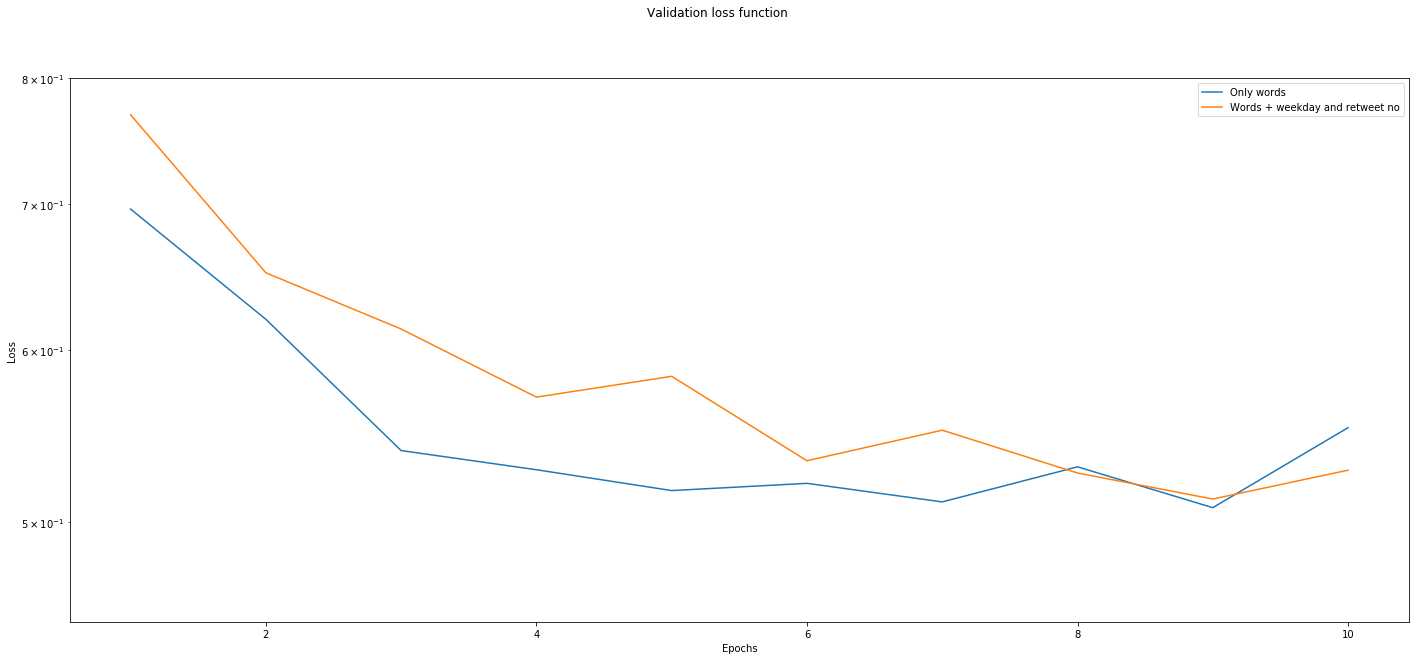

In [204]:
fig, ax = plt.subplots(1, 1, figsize=(24,10))
plt.suptitle('Validation loss function')

ax.set_ylim(0.45, 0.8)
ax.set_yscale("log")
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
    
ax.plot(epochs, val_loss[4], epochs, hist.history['val_loss'])
ax.legend(labels=['Only words', 'Words + weekday and retweet no'])
plt.show()

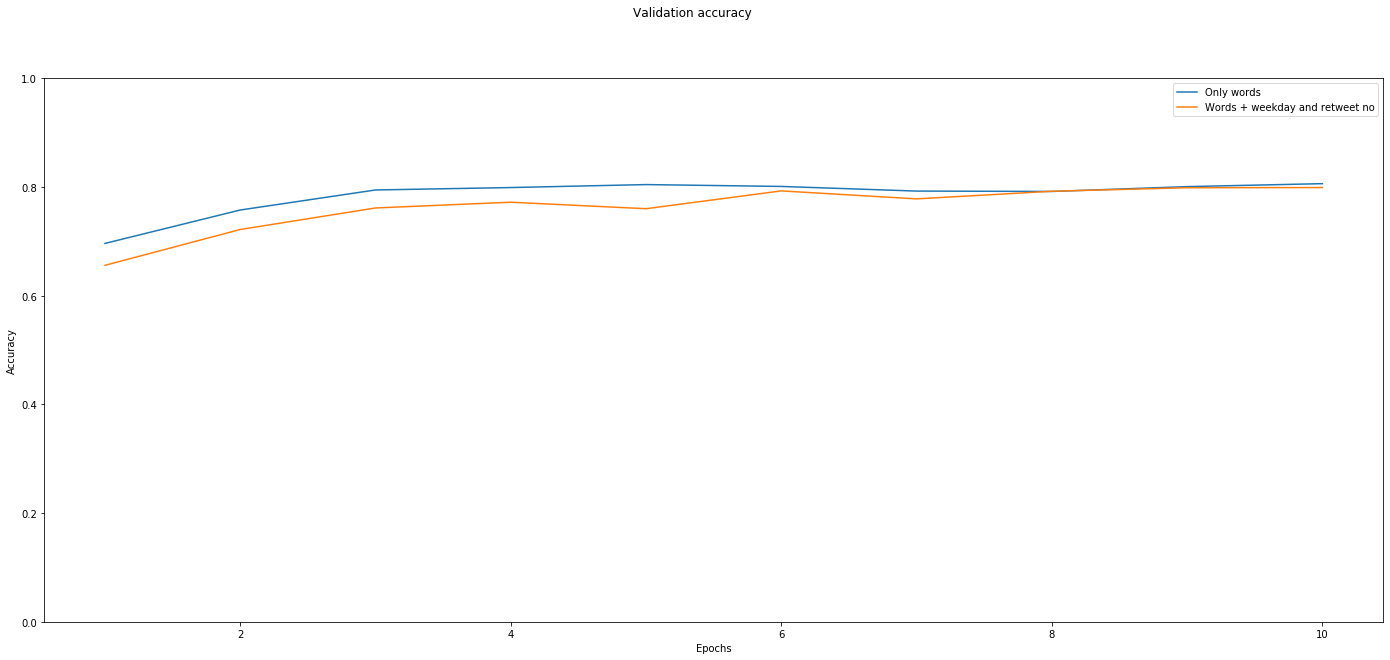

In [212]:
fig, ax = plt.subplots(1, 1, figsize=(24,10))
plt.suptitle('Validation accuracy')

ax.set_ylim(0, 1)
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
    
ax.plot(epochs, val_acc[4], epochs, hist.history['val_acc'])
ax.legend(labels=['Only words', 'Words + weekday and retweet no'])
plt.show()

# Gain of using additional featues is neglectable. I would stay with the model with the learning rate 0.0003 and the decay 1e-5 